# Plot model and calibration waveforms

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase,advanced_gmvx_plot

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


## The primary purpose of this notebook is to compare the values of theta eta and a1 in metadata to whats used in LAL. 
* The user needs to have compole LAL with the phenomx debug compile vairable enabled
* After recompiling without the DEBUG variable, one must `make clean` for the change to take effect

(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"
(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation
(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/
(notebook)>> Lastly, we are currently on this branch: pnrv1-ll
(notebook)>> Loading parameter space data.
>>  ****************************************  <<
>> simname =  q4a08t120dP1_T_96_360
>> theta =  120.36327626409718
>> eta =  0.15999880000799996
>> a1 =  0.7999800524931349
>>  ****************************************  <<
(notebook)>> Done.


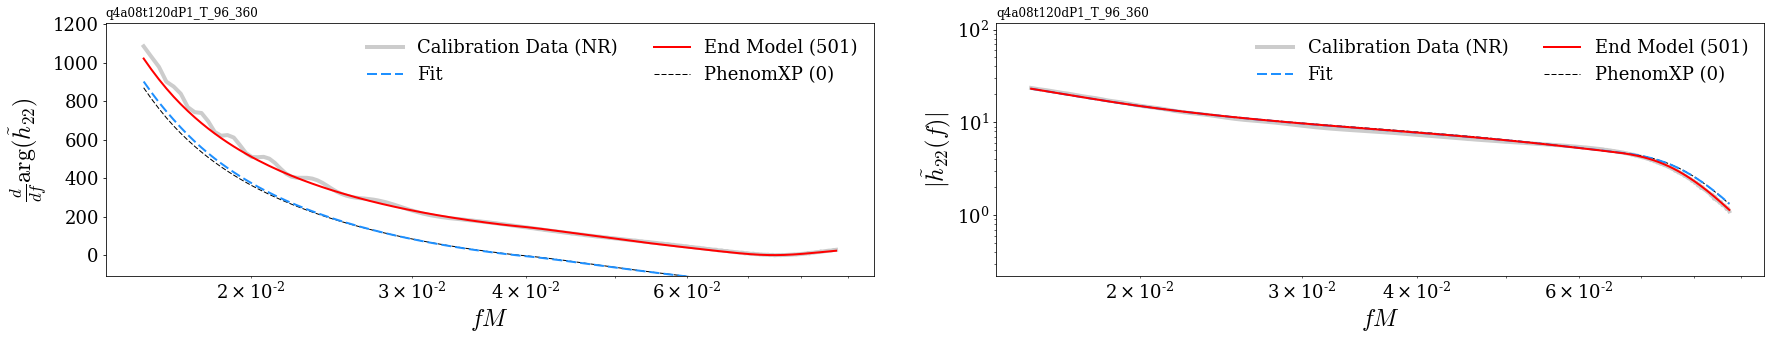

In [3]:
#!/usr/bin/env python3

# Setup the notebook's environment
import lalsimulation as lalsim
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from glob import glob
import xcp
from xcp import determine_data_fitting_region,calibration_catalog,metadata_dict,template_amp_phase

# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=True)
    
    
#

#
from numpy.linalg import norm
from scipy.optimize import curve_fit

#
ll = 2

# --------------------------------------- #
# Preliminaries
# --------------------------------------- #

#
alert('Loading parameter space data.')

# Define data location
package_dir = parent( xcp.__path__[0] )
datadir = package_dir + 'data/version2/'
files = glob( datadir+'*_l%im%i.txt'%(ll,ll) )
files.sort()
files = files[::-1]

# Load and unpack physical parameter space
opt_parameter_range = loadtxt(datadir+'fit_opt_parameters.txt')
scarecrow = template_amp_phase(0.5, 0.5,zeros(3),zeros(3),ell=2)
parameter_names_in_order = scarecrow.__code__.co_varnames[1:scarecrow.__code__.co_argcount]
model_range = {  parameter_names_in_order[k]:var for k,var in enumerate(opt_parameter_range.T) }

#
fig,ax = subplots( 1, 2, figsize=3*array([ 2.5*2/(0.618), 1.5*1 ]) )
# fig,ax = subplots( len(files), 2, figsize=3*array([ 2.5*2/(0.618), 1.5*len(files) ]) )
ax = ax.flatten()

#
tight_layout(w_pad=4,h_pad=4)

#
foo = {}

#
lmlist = [ (ll,ll) ]

#
p = 0
for j,f_ in enumerate(files):

    #
    simname = f_.split('/')[-1].split('_l%im%i.'%(ll,ll))[0]
    
    if 'q4a08t120' in simname:

        # Find index location of metadata for simname 
        k = [ k for k,val in enumerate(metadata_dict['simname']) if val in simname ][0]

        # Load data for this case
        raw_data = loadtxt(f_).T
        calibration_data, dphi_lorentzian_min, f_min, f_max, f_lorentzian_min = determine_data_fitting_region( raw_data )

        # Collect params for this case 
        metadata = metadata_dict['array_data'][k,:]

        #
        f,amp_fd,dphi_fd,alpha,beta,gamma = calibration_data.T
        theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2,chi1_x,chi1_y,chi1_z,chi2_x,chi2_y,chi2_z = metadata_dict['array_data'][k]
        chi1_vec = array([chi1_x,chi1_y,chi1_z])
        chi2_vec = array([chi2_x,chi2_y,chi2_z])

        #
        print('>> ','**'*20,' <<')
        print('>> simname = ',simname)
        print('>> theta = ',theta*180/pi)
        print('>> eta = ',eta)
        print('>> a1 = ',a1)
        print('>> ','**'*20,' <<')

        #dphi_fd -= min( dphi_fd[ (f>0.03)&(f<0.12) ] )

        #
        action_helper = template_amp_phase(m1, m2, chi1_vec, chi2_vec,ell=2)
        mod_xhm0_amp,mod_xhm0_dphi = action_helper(f)

        #
        popt = opt_parameter_range[j,:]
        opt_amp,opt_dphi = action_helper(f,*popt)

        #
        mod_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec, pflag=500 )
        mod_xhm = mod_xhm_dict[ll,ll]
        mod_xhm_amp = abs(mod_xhm)
        mod_xhm_phi = unwrap( angle(mod_xhm) )
        mod_xhm_dphi = spline_diff(f,mod_xhm_phi)
        mod_xhm_dphi -= min( mod_xhm_dphi[ (f>0.03)&(f<0.12) ] )

        #
        tuned_xhm_dict = xcp.get_phenomxphm_coprecessing_multipoles( f,lmlist, m1, m2, chi1_vec, chi2_vec, pflag=501 )
        tuned_xhm = tuned_xhm_dict[ll,ll]
        tuned_xhm_amp = abs(tuned_xhm)
        tuned_xhm_phi = unwrap( angle(tuned_xhm) )
        tuned_xhm_dphi = spline_diff(f,tuned_xhm_phi)
        tuned_xhm_dphi -= min( tuned_xhm_dphi[ (f>0.03)&(f<0.12) ] )

        # PLOTTING
        # ---

        #
        sca(ax[p]); p+=1
        plot( f, dphi_fd, label='Calibration Data (NR)', lw=4, alpha=0.2, color='k' )
        plot( f, opt_dphi, label='Fit', ls='--',lw=2,alpha=1,color='dodgerblue' )
        plot( f, tuned_xhm_dphi, label='End Model (501)', ls='-',lw=2,alpha=1,color='r' )
        # plot( f, mod_xhm_dphi, label='PhenomXP (500)', ls='-',lw=2,alpha=0.85,color='m' )
        plot( f, mod_xhm0_dphi, label='PhenomXP (0)', ls='--',lw=1,alpha=1,color='k',zorder=-10 )
        xscale('log')
        xlim(lim(f,dilate=1.1,dilate_with_multiply=True))
        ylim( limy(f, mod_xhm_dphi,dilate=0.1) )
        title(simname,size=12,loc='left')
        legend(ncol=2,loc=1)
        ylabel(r'$\frac{d}{df}\arg(\tilde{h}_{22})$')
        xlabel('$fM$')
        title(simname,loc='left',size=12)

        sca(ax[p]); p+=1
        plot( f, amp_fd, label='Calibration Data (NR)', lw=4, alpha=0.2, color='k' )
        plot( f, opt_amp, label='Fit', ls='--',lw=2,alpha=1,color='dodgerblue' )
        plot( f, tuned_xhm_amp, label='End Model (501)', ls='-',lw=2,alpha=1,color='r' )
        # plot( f, mod_xhm_amp, label='PhenomXP (500)', ls='-',lw=2,alpha=0.85,color='m' )
        plot( f, mod_xhm0_amp, label='PhenomXP (0)', ls='--',lw=1,alpha=1,color='k',zorder=-10 )
        yscale('log')
        xscale('log')
        legend(ncol=2)
        ylim( limy(f, amp_fd,dilate=5) )
        xlabel('$fM$')
        ylabel(r'$|\tilde{h}_{22}(f)|$')
        #
        title(simname,loc='left',size=12)
        break
        
        
#
# file_path = datadir+'waveform_postfit_diagnostic_l%im%i.pdf'%(ll,ll)
# alert('Saving batch plot to %s'%magenta(file_path))
# savefig(file_path,pad_inches=2, bbox_inches = "tight")
alert('Done.')